# Creating an AI application for breast cancer detection

Early detection of breast cancer can increase treatment efficiency. Architectural Distortion (AD) is a very subtle contraction of the breast tissue and may represent the earliest sign of cancer. Since it is very likely to be unnoticed by radiologists, several approaches have been proposed over the years but none using deep learning techniques. 


# Breast Cancer Histopathological Database (BreakHis)


The dataset BreaKHis is divided into two main groups: benign tumors and malignant tumors. Histologically benign is a term referring to a lesion that does not match any criteria of malignancy – e.g., marked cellular atypia, mitosis, disruption of basement membranes, metastasize, etc. Normally, benign tumors are relatively “innocents”, presents slow growing and remains localized. Malignant tumor is a synonym for cancer: lesion can invade and destroy adjacent structures (locally invasive) and spread to distant sites (metastasize) to cause death. I divided the full dataset in training and validation datasets 70% and 30%, respectively.

# Installing and Importing the libraries
First up is importing the packages you'll need:

In [1]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# Let's verify the version
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
!pip install image
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [2]:
# We will verify that GPU is enabled for this notebook
# Following should print: CUDA is available!  Training on GPU ...
# if it prints otherwise, then you need to enable GPU(Colab): 
# From Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


# Load the data

For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 227x227 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from 'torchvision' were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's ' [0.485, 0.456, 0.406]'  and for the standard deviations ''[0.229, 0.224, 0.225]' , calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# I made a smaller version of the dataset, original ones have classes and subclasses.
# I just wanted to keep 2 classes: benign and malignant. You can get the dataset from here:
#Download and unzip de folder
!gdown https://drive.google.com/uc?id=1rqd9bgLzlNNrbjjPog3jZKUHUmZWPDaA
!unzip -qq cancer_data.zip

Downloading...
From: https://drive.google.com/uc?id=1rqd9bgLzlNNrbjjPog3jZKUHUmZWPDaA
To: /content/cancer_data.zip
4.28GB [00:38, 111MB/s]


In [0]:
data_dir = '/cancer_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# Label mapping

I created a json file to map the categories. You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plant diseases.

In [5]:
import json
!gdown https://drive.google.com/uc?id=15tU03GDvMzUg7Nax708sqq2lbb-EcrhQ
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

Downloading...
From: https://drive.google.com/uc?id=15tU03GDvMzUg7Nax708sqq2lbb-EcrhQ
To: /content/cat_to_name.json
100% 41.0/41.0 [00:00<00:00, 38.0kB/s]


In [0]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(90),
        transforms.RandomRotation(180),
        transforms.RandomRotation(270),
        transforms.RandomResizedCrop(227),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir = 'cancer_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. I got Alexnet to see how it works. Build and train a new feed-forward classifier using those features.

In [7]:
# Build and train your network

# 1. Load alexnet pre-trained network
model = models.alexnet(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:04<00:00, 52252961.51it/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(256 * 6 * 6, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.3)),
                          ('fc2',nn.Linear(4096, 4096)),
                          ('relu', nn.ReLU()),
                          #('dropout2', nn.Dropout(p=0.3)),
                          ('fc3', nn.Linear(4096, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))



# Replacing the pretrained model classifier with our classifier
model.classifier = classifier

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# Train a model with a pre-trained network
num_epochs = 15
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = torch.nn.CrossEntropyLoss()

# Adam optimizer with a learning rate
# Optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
optimizer = optim.SGD(model.classifier.parameters(), lr = .001, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Using GPU: True
Epoch 1/15
----------
train Loss: 0.4212 Acc: 0.8264
valid Loss: 0.6202 Acc: 0.7429

Epoch 2/15
----------
train Loss: 0.3556 Acc: 0.8683
valid Loss: 0.5791 Acc: 0.7922

Epoch 3/15
----------
train Loss: 0.3156 Acc: 0.8806
valid Loss: 0.8663 Acc: 0.6410

Epoch 4/15
----------
train Loss: 0.3076 Acc: 0.8817
valid Loss: 0.6435 Acc: 0.7442

Epoch 5/15
----------
train Loss: 0.2845 Acc: 0.8922
valid Loss: 0.8328 Acc: 0.6730

Epoch 6/15
----------
train Loss: 0.2745 Acc: 0.8936
valid Loss: 0.6573 Acc: 0.7425

Epoch 7/15
----------
train Loss: 0.2610 Acc: 0.8996
valid Loss: 0.6652 Acc: 0.7324

Epoch 8/15
----------
train Loss: 0.2558 Acc: 0.9023
valid Loss: 0.6171 Acc: 0.7577

Epoch 9/15
----------
train Loss: 0.2538 Acc: 0.9062
valid Loss: 0.6355 Acc: 0.7531

Epoch 10/15
----------
train Loss: 0.2498 Acc: 0.9061
valid Loss: 0.6535 Acc: 0.7408

Epoch 11/15
----------
train Loss: 0.2451 Acc: 0.9090
valid Loss: 0.6622 Acc: 0.7370

Epoch 12/15
----------
train Loss: 0.2486 Acc: 

In [0]:
#Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))



In [12]:
test(model, dataloaders, device)

Testing Accuracy: 0.010
Testing Accuracy: 0.021
Testing Accuracy: 0.031
Testing Accuracy: 0.041
Testing Accuracy: 0.052
Testing Accuracy: 0.063
Testing Accuracy: 0.075
Testing Accuracy: 0.084
Testing Accuracy: 0.095
Testing Accuracy: 0.106
Testing Accuracy: 0.117
Testing Accuracy: 0.127
Testing Accuracy: 0.139
Testing Accuracy: 0.151
Testing Accuracy: 0.162
Testing Accuracy: 0.174
Testing Accuracy: 0.185
Testing Accuracy: 0.195
Testing Accuracy: 0.206
Testing Accuracy: 0.217
Testing Accuracy: 0.229
Testing Accuracy: 0.239
Testing Accuracy: 0.248
Testing Accuracy: 0.258
Testing Accuracy: 0.267
Testing Accuracy: 0.277
Testing Accuracy: 0.288
Testing Accuracy: 0.299
Testing Accuracy: 0.310
Testing Accuracy: 0.320
Testing Accuracy: 0.332
Testing Accuracy: 0.343
Testing Accuracy: 0.355
Testing Accuracy: 0.365
Testing Accuracy: 0.374
Testing Accuracy: 0.383
Testing Accuracy: 0.394
Testing Accuracy: 0.405
Testing Accuracy: 0.416
Testing Accuracy: 0.428
Testing Accuracy: 0.438
Testing Accuracy

# Save the checkpoint

Now that the network is trained,  we will save the model so we can load it later for making predictions. We will save the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We will attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we'll want to completely rebuild the model later so we can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# Save the checkpoint 

model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 227, 227],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'mamo2018_checkpoint.pth')

# Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.alexnet()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 4096
    output_size = 2
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(256 * 6 * 6, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.3)),
                          ('fc2',nn.Linear(4096, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout2', nn.Dropout(p=0.3)),
                          ('fc3', nn.Linear(4096, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.classifier = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('mamo2018_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the plant disease in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 


In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 227, 227
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [19]:
print (predict('cancer_data/valid/benigno/SOB_B_PT-14-22704-100-006.png', loaded_model))

(array([0.5713976 , 0.42860243], dtype=float32), ['maligno', 'benigno'])


# Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top class as a bar graph, along with the input image. It should look like this:


In [0]:
# Display an image along with the top class

def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

In [21]:
print (predict('cancer_data/valid/maligno/SOB_M_MC-14-18842-200-002.png', loaded_model))

(array([0.96553916, 0.03446085], dtype=float32), ['maligno', 'benigno'])


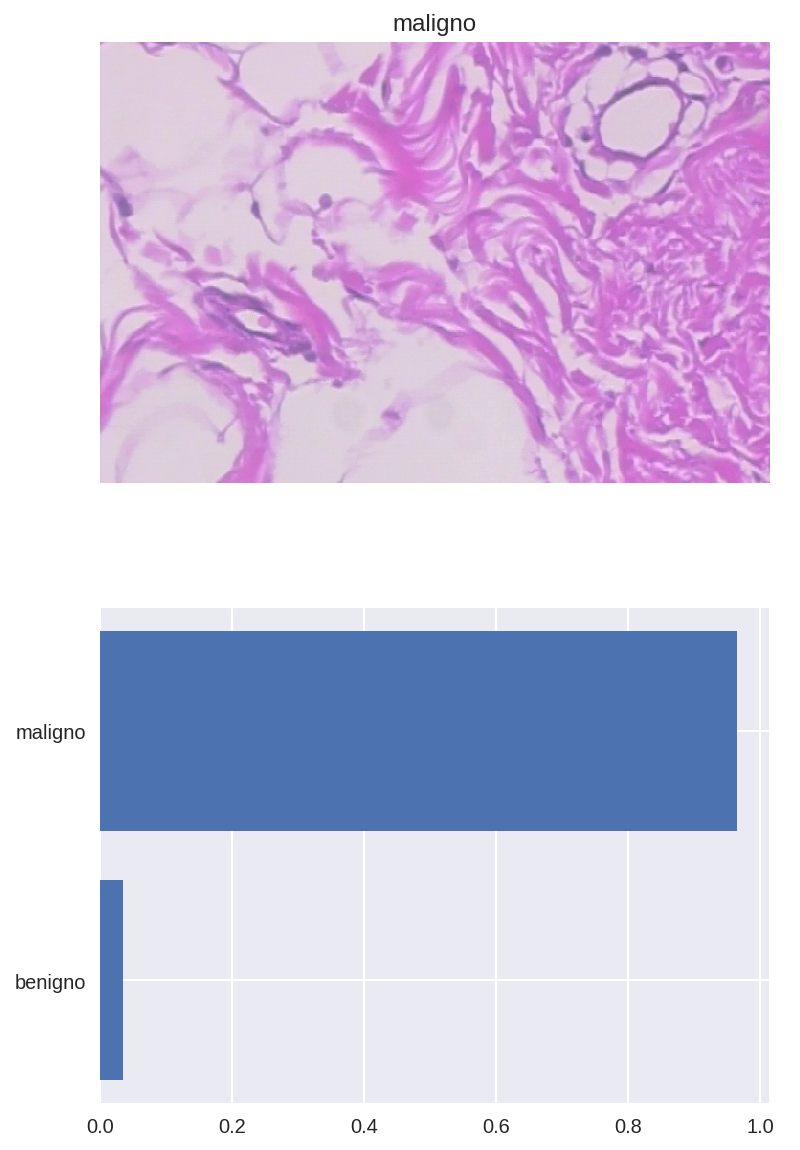

In [22]:
img = 'cancer_data/valid/maligno/SOB_M_MC-14-18842-200-002.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

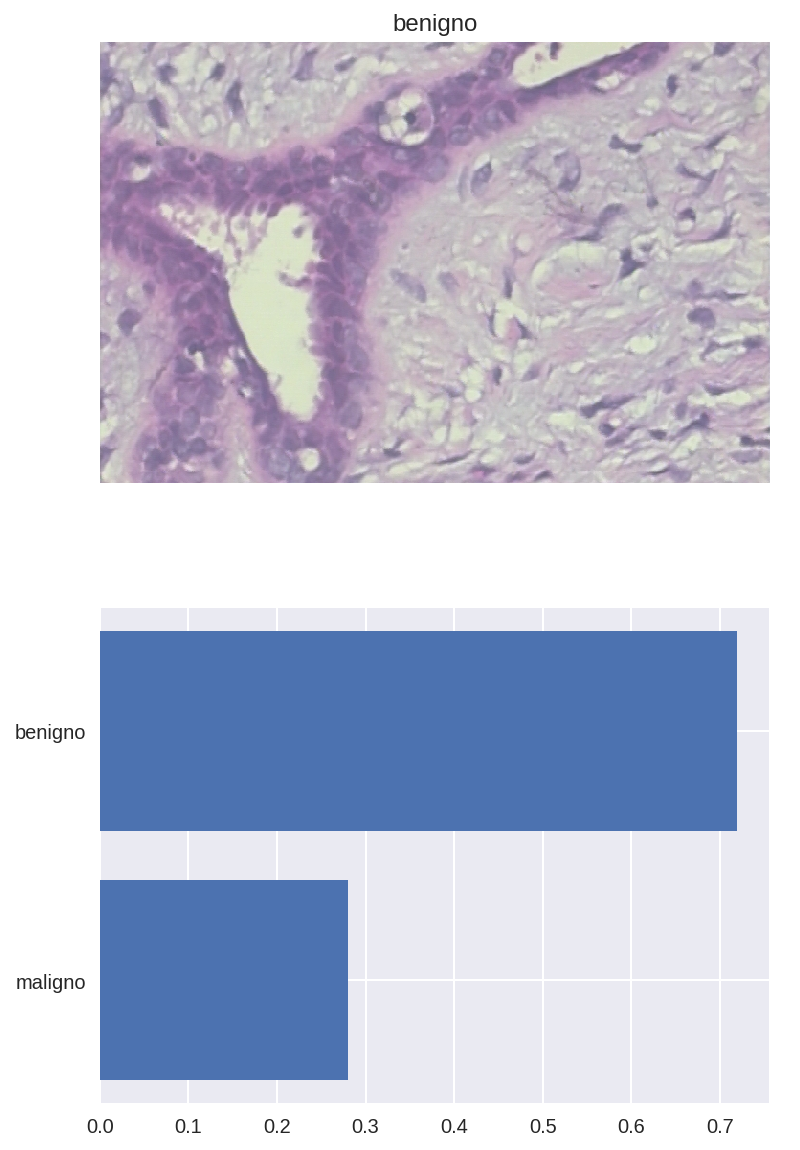

In [31]:
img = 'cancer_data/valid/benigno/SOB_B_PT-14-22704-200-032.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)